In [79]:
import warnings
warnings.filterwarnings('ignore')
import os
import re
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('train.csv')

In [6]:
df['question1'] = df['question1'].apply(lambda x : str(x))
df['question2'] = df['question2'].apply(lambda x : str(x))

In [7]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [17]:
questions = list(df['question1']) + list(df['question2'])
tfidf = TfidfVectorizer()
tfidf.fit_transform(questions)

word2tfidf = dict(zip(tfidf.get_feature_names() , tfidf.idf_))

In [8]:
!python -m spacy download en_core_web_lg
# !python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_md
!python -m spacy download en

  Using cached pydantic-1.8.2-cp39-cp39-win_amd64.whl (1.9 MB)
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.9.0
    Uninstalling pydantic-1.9.0:
      Successfully uninstalled pydantic-1.9.0
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


2022-09-03 09:13:32.693655: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-09-03 09:13:32.693688: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the full
pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2022-09-03 09:15:01.374017: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-09-03 09:15:01.374049: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
nlp = spacy.load('en_core_web_lg')

In [19]:
vecs1 = []
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1)
    mean_vec1 = np.zeros([len(doc1) , len(doc1[0].vector)])
    for word in doc1 :
        vec1 = word.vector
        try :
            idf = word2tfidf[str(word)]
        except :
            idf = 0
        
        mean_vec1 += vec1 *idf
    mean_vec1 = mean_vec1.mean(axis = 0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

100%|██████████| 404290/404290 [26:45<00:00, 251.86it/s]


In [21]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2)
    mean_vec2 = np.zeros([len(doc2) , len(doc2[0].vector)])
    for word in doc2 :
        vec2 = word.vector
        try:
            idf = word2tfidf[str(word)]
        except :
            idf = 0
        
        mean_vec2+=vec2*idf
    
    mean_vec2 = mean_vec2.mean(axis = 0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 404290/404290 [27:10<00:00, 248.02it/s]


In [27]:
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [30]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [31]:
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-3.198352,15.077722,3.437450,8.776460,17.840812,-5.495483,-4.486137,-1.984797,7.068444,137.474359,...,-17.271256,6.053453,1.172296,-8.341404,-1.916135,-10.751976,-11.810194,2.567493,1.555717,14.659395
1,-0.538702,3.637158,-1.590220,-0.876835,-2.886816,1.083482,0.012321,-0.896733,1.626932,37.200250,...,-4.803396,0.853687,-1.367386,-1.363772,-1.109043,-0.802511,-3.131167,-0.961089,-1.362053,0.959924
2,-1.655994,13.931494,-11.802408,-4.951214,-4.028308,8.171741,1.994853,-6.121891,2.118071,103.784238,...,-19.861408,0.090278,8.375016,-3.129866,8.501135,2.134073,4.606726,-2.426892,-8.318245,14.592223
3,-3.724989,14.498072,-13.149833,1.766297,-1.923388,-0.823435,2.507192,-8.287452,2.203317,99.647793,...,-2.177166,-4.892293,0.146928,-1.364719,7.682195,2.729714,6.366254,-2.170255,-5.234310,0.907066
4,-12.058621,19.427898,-5.097120,-5.068274,-21.625187,33.197954,-30.637264,1.787574,-19.337745,72.103688,...,-6.093323,-5.232206,18.731823,-39.859567,-9.775420,16.033650,-0.901726,-8.243858,-8.747795,23.431057


In [32]:
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.463598,12.749275,-0.040525,9.574959,13.513271,-4.950747,-5.104401,-0.494763,5.010109,127.815271,...,-17.438518,7.209327,1.669276,-7.364949,-0.303803,-11.582201,-10.465199,1.609623,3.137831,11.497658
1,-6.417909,6.134723,2.025913,1.637761,-5.359829,-1.668739,-0.983203,-8.701693,-7.945154,123.984406,...,-11.014318,9.428450,6.915866,2.051589,8.447017,-1.200856,-9.805973,0.816827,2.088064,9.974840
2,-12.220201,13.806673,-0.906916,-2.387971,-4.504945,-2.109954,4.184776,2.090956,-3.065267,80.964309,...,-16.348346,-1.212045,11.968852,2.826939,1.145123,4.681075,1.010644,7.619947,-7.878451,17.310574
3,3.042936,-0.706344,3.375969,1.292883,-1.614348,-3.616190,-9.559777,4.785282,4.556000,69.755430,...,-2.729503,1.651121,0.072952,-1.613949,-5.770356,-0.189960,-3.332227,-8.699733,0.712742,-8.369226
4,-6.323836,1.232667,1.431262,-2.799651,-4.190380,8.607565,-24.560574,8.135008,-3.041029,77.558523,...,-7.948190,-8.457366,-14.739021,-12.656514,-3.498509,13.284102,-11.563425,-15.367697,2.753520,-9.836051


In [33]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 300
Number of features in question2 w2v  dataframe : 300
Number of features in final dataframe  : 629


In [34]:
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

In [39]:
data = result.copy()

In [40]:
data.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,...,-17.438518,7.209327,1.669276,-7.364949,-0.303803,-11.582201,-10.465199,1.609623,3.137831,11.497658
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,...,-11.014318,9.428450,6.915866,2.051589,8.447017,-1.200856,-9.805973,0.816827,2.088064,9.974840
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,...,-16.348346,-1.212045,11.968852,2.826939,1.145123,4.681075,1.010644,7.619947,-7.878451,17.310574
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,-2.729503,1.651121,0.072952,-1.613949,-5.770356,-0.189960,-3.332227,-8.699733,0.712742,-8.369226
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,...,-7.948190,-8.457366,-14.739021,-12.656514,-3.498509,13.284102,-11.563425,-15.367697,2.753520,-9.836051


In [41]:
y_true = data['is_duplicate']
data.drop(['is_duplicate' , 'id'] , axis = 1 , inplace = True)

In [43]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,...,-17.438518,7.209327,1.669276,-7.364949,-0.303803,-11.582201,-10.465199,1.609623,3.137831,11.497658
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,...,-11.014318,9.428450,6.915866,2.051589,8.447017,-1.200856,-9.805973,0.816827,2.088064,9.974840
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,...,-16.348346,-1.212045,11.968852,2.826939,1.145123,4.681075,1.010644,7.619947,-7.878451,17.310574
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,...,-2.729503,1.651121,0.072952,-1.613949,-5.770356,-0.189960,-3.332227,-8.699733,0.712742,-8.369226
4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,...,-7.948190,-8.457366,-14.739021,-12.656514,-3.498509,13.284102,-11.563425,-15.367697,2.753520,-9.836051


In [45]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(data , y_true , stratify = y_true , test_size = 0.3)

In [46]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 626)
Number of data points in test data : (121287, 626)


In [75]:
from sklearn.metrics import confusion_matrix

In [76]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Building A Random Model (to find the worst case log loss)

In [81]:
from sklearn.metrics import log_loss
import seaborn as sns

Log loss using random model : 0.8844848693101672


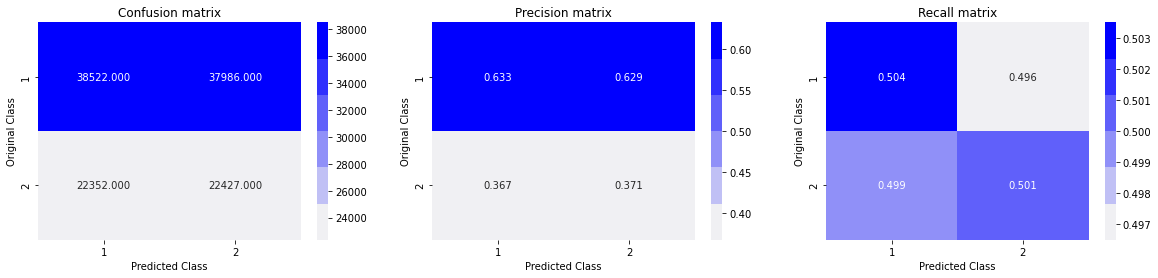

In [82]:
predicted_y = np.zeros((len(y_test) , 2))
for i in range(len(y_test)):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])

print('Log loss using random model :' , log_loss(y_test , predicted_y , eps = 1e-15))
predicted_y = np.argmax(predicted_y , axis = 1)
plot_confusion_matrix(y_test , predicted_y)

# Logistric Regression with Hyperparameter Tuning

In [90]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

In [94]:
alpha = [10**x for x in range(-5,2)]
log_error_array= []
for i in alpha :
    clf = SGDClassifier(alpha = i , penalty = 'l2' , loss = 'log' , random_state = 42)
    clf.fit(X_train , y_train)
    sig_clf = CalibratedClassifierCV(clf , method = 'sigmoid')
    sig_clf.fit(X_train , y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test , predict_y , labels = clf.classes_ , eps = 1e-15))
    print('The log loss for the value of alpha = {} is {}'.format(i , log_loss(y_test , predict_y , labels = clf.classes_ , eps = 1e-15)))

The log loss for the value of alpha = 1e-05 is 0.4393959941567248
The log loss for the value of alpha = 0.0001 is 0.4445938288205473
The log loss for the value of alpha = 0.001 is 0.4478233148447109
The log loss for the value of alpha = 0.01 is 0.414496337408334
The log loss for the value of alpha = 0.1 is 0.4240729970740185
The log loss for the value of alpha = 1 is 0.46160331052473724
The log loss for the value of alpha = 10 is 0.5155945078343319


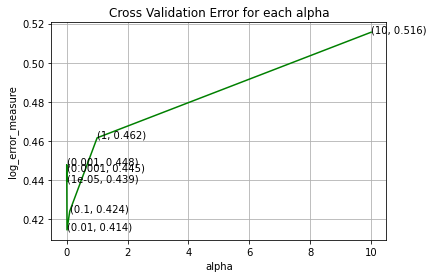

train error is :  0.4889807789534389
test error is :  0.4877386971888237


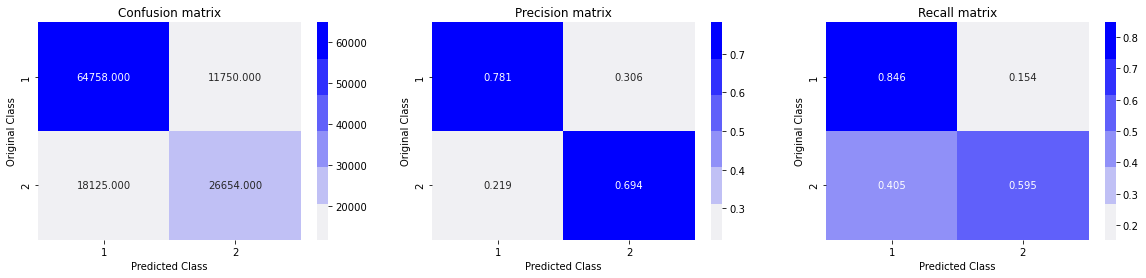

In [96]:
fig , ax = plt.subplots()
ax.plot(alpha , log_error_array , c = 'g')
for i , text in enumerate(np.round(log_error_array , 3)):
    ax.annotate((alpha[i] , np.round(text,3)) , (alpha[i] , log_error_array[i]))
plt.grid()
plt.title('Cross Validation Error for each alpha')
plt.xlabel('alpha')
plt.ylabel('log_error_measure')
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha = best_alpha , penalty = 'l2' , loss = 'log' , random_state = 42)
clf.fit(X_train , y_train)
sig_clf = CalibratedClassifierCV(clf , method = 'sigmoid')
sig_clf.fit(X_train , y_train)

predict_y = sig_clf.predict_proba(X_train)
print('train error is : ' , log_loss(y_train , predict_y , labels = clf.classes_ , eps = 1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('test error is : ' , log_loss(y_test , predict_y , labels = clf.classes_ , eps = 1e-15))
predicted_y = np.argmax(predict_y , axis = 1)
plot_confusion_matrix(y_test , predicted_y)

# Linear SVM with hyperparameter tuning

The log loss for the value of alpha = 1e-05 is 0.43551413912738285
The log loss for the value of alpha = 0.0001 is 0.4453230009053013
The log loss for the value of alpha = 0.001 is 0.4425542055486579
The log loss for the value of alpha = 0.01 is 0.41802948730060746
The log loss for the value of alpha = 0.1 is 0.41935060400112717
The log loss for the value of alpha = 1 is 0.4491074537051341
The log loss for the value of alpha = 10 is 0.49966005037997874


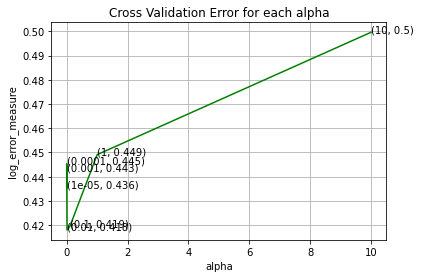

train error is :  0.47360008318976055
test error is :  0.47254408866412617


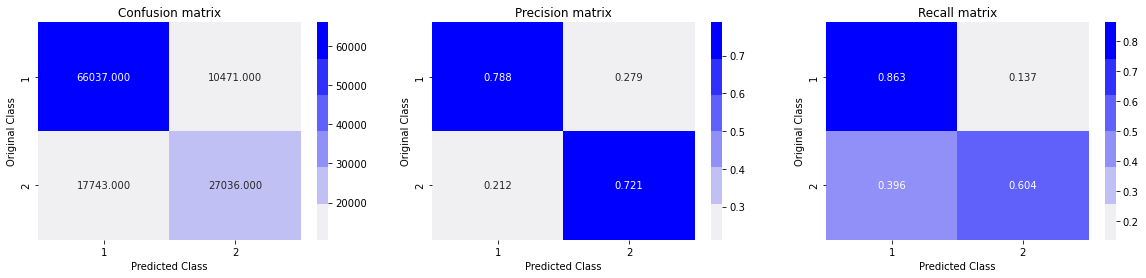

In [98]:
alpha = [10**x for x in range(-5,2)]
log_error_array= []
for i in alpha :
    clf = SGDClassifier(alpha = i , penalty = 'l2' , loss = 'hinge' , random_state = 42)
    clf.fit(X_train , y_train)
    sig_clf = CalibratedClassifierCV(clf , method = 'sigmoid')
    sig_clf.fit(X_train , y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test , predict_y , labels = clf.classes_ , eps = 1e-15))
    print('The log loss for the value of alpha = {} is {}'.format(i , log_loss(y_test , predict_y , labels = clf.classes_ , eps = 1e-15)))

fig , ax = plt.subplots()
ax.plot(alpha , log_error_array , c = 'g')
for i , text in enumerate(np.round(log_error_array , 3)):
    ax.annotate((alpha[i] , np.round(text,3)) , (alpha[i] , log_error_array[i]))
plt.grid()
plt.title('Cross Validation Error for each alpha')
plt.xlabel('alpha')
plt.ylabel('log_error_measure')
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha = best_alpha , penalty = 'l2' , loss = 'hinge' , random_state = 42)
clf.fit(X_train , y_train)
sig_clf = CalibratedClassifierCV(clf , method = 'sigmoid')
sig_clf.fit(X_train , y_train)

predict_y = sig_clf.predict_proba(X_train)
print('train error is : ' , log_loss(y_train , predict_y , labels = clf.classes_ , eps = 1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('test error is : ' , log_loss(y_test , predict_y , labels = clf.classes_ , eps = 1e-15))
predicted_y = np.argmax(predict_y , axis = 1)
plot_confusion_matrix(y_test , predicted_y)

# XGBoost with Hyperparameter Tuning

In [99]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
classifier = XGBClassifier()

In [111]:
params = {
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ],
 'lambda' : [1 , 10 , 100]
}

In [112]:
model = RandomizedSearchCV(classifier , param_distributions = params , n_iter = 2 , scoring = 'roc_auc' , cv = 5 , verbose = 2 , n_jobs = -1)

In [ ]:
model.fit(X_train , y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [107]:
clf = model.best_estimator_

In [109]:
clf.fit(X_train , y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

train error is :  0.1120841503653858
test error is :  0.3235816700551536


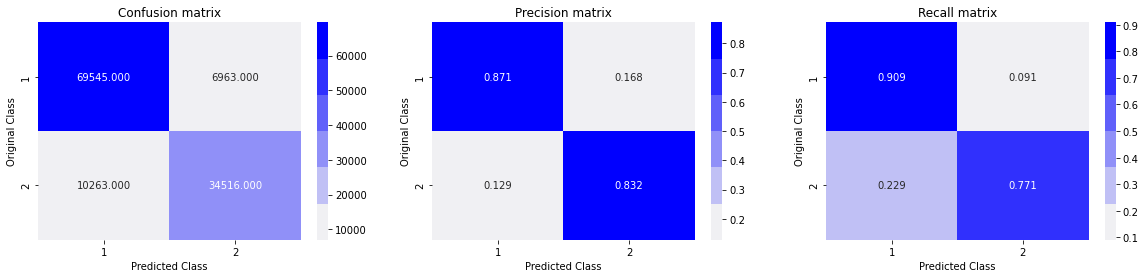

In [110]:
sig_clf = CalibratedClassifierCV(clf , method = 'sigmoid')
sig_clf.fit(X_train , y_train)
predict_y = sig_clf.predict_proba(X_train)
print('train error is : ' , log_loss(y_train , predict_y , labels = clf.classes_ , eps = 1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('test error is : ' , log_loss(y_test , predict_y , labels = clf.classes_ , eps = 1e-15))
predicted_y = np.argmax(predict_y , axis = 1)
plot_confusion_matrix(y_test , predicted_y)